# Imports, install and mount

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# %pwd
# print("DRIVE MOUNTED")

In [2]:
# ! pip install cuda
# ! pip install torch_geometric
# ! pip install dgl
# ! pip install nxontology
# ! pip install tensordict
# # ! pip install numpy==1.22.1
# ! pip install pandas
# ! pip install tensorflow
# ! pip install scipy
# ! pip install pydantic
# ! pip install matplotlib

import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import dgl
import os
from torch.nn.functional import normalize
from tensordict.tensordict import TensorDict

from nxontology.imports import from_file
import tensorflow as tf
#



/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/elliot/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-19 14:23:06.457050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 14:23:06.489453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 14:23:07.081723: W tensorflow/compiler/tf2tensorrt/utils/py_

# Settings


In [3]:
# ComplEx embeddings :

hidden_channels = 10
batch_size = 4096
epochs = 5
file_path = "/home/elliot/Documents/ESL2024/data/little_genes_to_phenotypes_iric.tsv"
# file_path = "/home/elliot/Documents/ESL2024/data/little_iric.tsv"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # Tip : Use cpu for debugging
print(device)


# Losses tests :

n_negative_triplets_per_positive = 4 # Number of false negatives triples per positive triple in the dataset for losses tests.
url = "https://purl.obolibrary.org/obo/go/go-basic.json.gz" # Where should I look for GO ?

cpu


/home/elliot/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Preparing ComplEx embeddings

## TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [4]:
iric = pd.read_csv(file_path, delimiter='\t', names = ['subject', 'predicate','object'])
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: int(i) for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: int(i) for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)

print('OK')
print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}

print("Mapping to entity dict :",mapping_to_entity)
print("Mapping to relation dict",mapping_to_relation)

,subject,predicate,object
0,OsNippo01g010050,gene ontology,GO:0031267
1,OsNippo01g010050,gene ontology,GO:0006886
2,OsNippo01g010050,gene ontology,GO:0005622
3,OsNippo01g010050,gene ontology,GO:0005623
4,OsNippo01g010050,gene ontology,GO:0090630
...,...,...,...
9996,OsNippo01g223000,gene ontology,GO:0005784
9997,OsNippo01g223050,gene ontology,GO:0005634
9998,OsNippo01g223050,gene ontology,GO:0005737
9999,OsNippo01g223050,gene ontology,GO:0003676


,subject,predicate,object
0,747,0,1926
1,747,0,390
2,747,0,1526
3,747,0,248
4,747,0,1634
...,...,...,...
9996,516,0,387
9997,221,0,2558
9998,221,0,3234
9999,221,0,3079


OK
Minima in mappings :
subject : 0
predicate : 0
object : 1
{'OsNippo01g184950': 0, 'GO:0016706': 1, 'GO:0098791': 2, 'GO:0051017': 3, 'GO:0090406': 4, 'OsNippo01g098450': 5, 'OsNippo01g132700': 6, 'OsNippo01g083850': 7, 'GO:0015605': 8, 'GO:2000028': 9, 'GO:0035101': 10, 'OsNippo01g054650': 11, 'OsNippo01g129400': 12, 'GO:0003333': 13, 'OsNippo01g098000': 14, 'OsNippo01g121450': 15, 'OsNippo01g010450': 16, 'GO:0004525': 17, 'GO:0061815': 18, 'GO:0016811': 19, 'OsNippo01g030050': 20, 'OsNippo01g030500': 21, 'OsNippo01g084950': 22, 'GO:0007189': 23, 'GO:0004816': 24, 'GO:0000139': 25, 'OsNippo01g119550': 26, 'OsNippo01g016250': 27, 'GO:0008139': 28, 'OsNippo01g077000': 29, 'GO:0009416': 30, 'GO:0030836': 31, 'GO:0007095': 32, 'OsNippo01g062250': 33, 'GO:0006624': 34, 'GO:1990238': 35, 'GO:0005315': 36, 'GO:0006897': 37, 'GO:0009908': 38, 'GO:0050897': 39, 'OsNippo01g013050': 40, 'GO:0030976': 41, 'OsNippo01g147450': 42, 'OsNippo01g074950': 43, 'GO:0009660': 44, 'OsNippo01g130000': 45, 

## Building init vars for Data :

In [5]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[ 747,  747,  747,  ...,  221,  221,  221],
        [1926,  390, 1526,  ..., 3234, 3079, 2063]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Dataset looks valid ? 
 True


## Setting up datas and model


## Splitting dataset

In [6]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9001], edge_attr=[9001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])
Number of edges in datasets : 
  Train: 8001

  Test : 2000

  Validation : 2000


 3343
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[3209,  308,  174,  ..., 1810,  570, 2060],
        [ 318,  481,  323,  ..., 3298,  266, 1061]]), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0]), 'num_nodes': 3343, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.]), 'edge_label_index': tensor([[3209,  308,  174,  ..., 1810,  570, 2060],
        [ 31

## Iniating model

In [7]:
model = ComplEx(
    num_nodes=train_data.num_nodes,
    # num_relations=train_data.num_edge_types,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
    # neg_sampling = 4
)

optimizer = optim.Adam(model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

## Training and testing ComplEx

In [8]:
@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():
    model.train()
    total_loss = total_examples = 0

    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

torch.set_grad_enabled(True)
model.to(device)

model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

100%|██████████| 9001/9001 [00:08<00:00, 1020.80it/s]


Start Test Mean Rank: 1676.54, Start Test MRR: 0.0024, Start Test Hits@10: 0.0020
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6931


100%|██████████| 9001/9001 [00:08<00:00, 1012.46it/s]

Start Test Mean Rank: 1676.54, Start Test MRR: 0.0024, Start Test Hits@10: 0.0020
Final Test Mean Rank: 1406.22, Final Test MRR: 0.0048, Final Test Hits@10: 0.0064


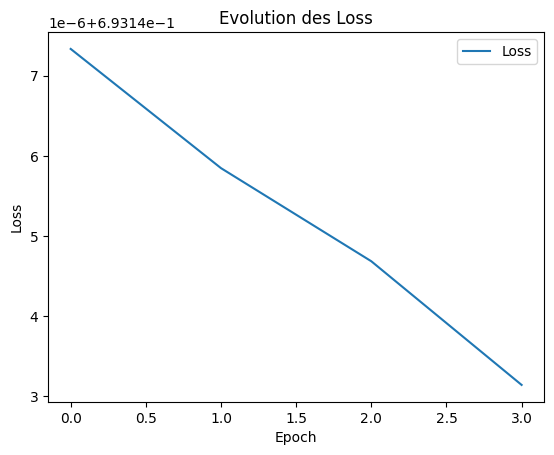

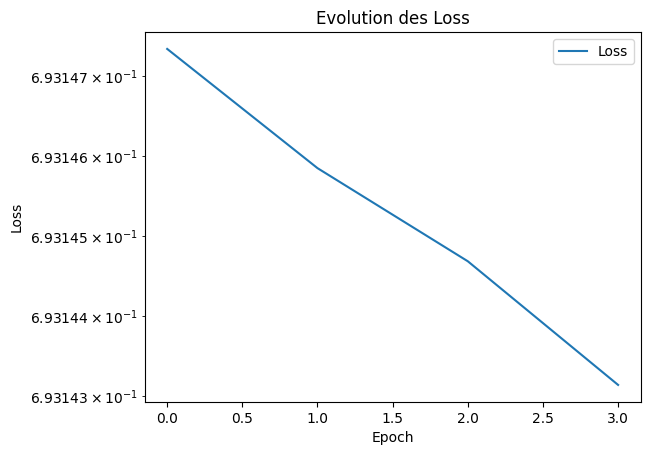

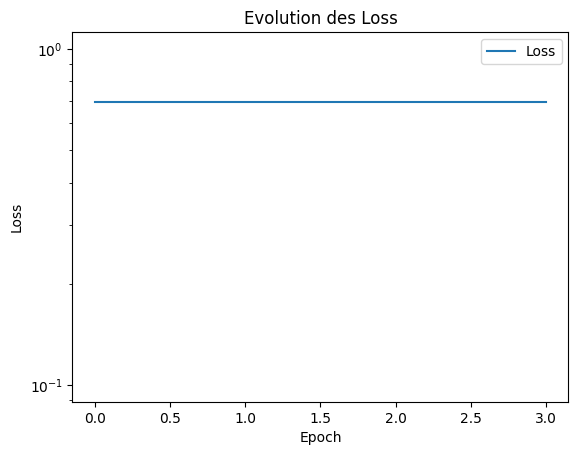

In [9]:
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider 
                                  # ahead and behind the pos X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

## Making dict for association of embeddings and IDs (GO:XXXX)

In [10]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Documents/ESL2024/code/TestComplEx


In [11]:
model.to('cpu')
torch.set_grad_enabled(False)

# Is model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))



print("Bad scores should appear here :")
print(model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))
print(model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))

Good score should appear here :
tensor(9.9627e-05)
Bad scores should appear here :
tensor(4.0769e-05)
tensor(9.1818e-05)


Attributs pour accéder aux embeddings :

        head_re = self.node_emb(head_index)
        head_im = self.node_emb_im(head_index)
        rel_re = self.rel_emb(rel_type)
        rel_im = self.rel_emb_im(rel_type)
        tail_re = self.node_emb(tail_index)
        tail_im = self.node_emb_im(tail_index)

In [12]:
# Extracting embeddings for each entity and relation in dicts.

entities_mapping_to_embedding = {}
relation_mapping_to_embedding = {}

for entity in entity_set:
    entity_id = entity_to_mapping[entity]

    real_part = model.node_emb(torch.tensor(entity_id))
    im_part = model.node_emb_im(torch.tensor(entity_id))

    embedding = torch.cat((real_part, im_part))

    entities_mapping_to_embedding[entity_id] = embedding

for relation in relation_set:
    relation_id = relation_to_mapping[relation]

    real_part = model.rel_emb(torch.tensor(relation_id))
    im_part = model.rel_emb_im(torch.tensor(relation_id))

    embedding = torch.cat((real_part, im_part))

    relation_mapping_to_embedding[relation_id] = embedding

In [13]:
relation_mapping_to_embedding

{0: tensor([ 0.0199, -0.0107,  0.0155,  0.0326,  0.0186,  0.0045,  0.0210,  0.0034,
          0.0237, -0.0108, -0.0130, -0.0012, -0.0099,  0.0331, -0.0301, -0.0063,
         -0.0047, -0.0148, -0.0112,  0.0005])}

In [14]:
# Making the reverse dicts :

entities_embedding_to_mapping ={v: k for k, v in entities_mapping_to_embedding.items()}
relation_embedding_to_mapping = {v: k for k, v in relation_mapping_to_embedding.items()}

# Quick check :

def get_key_value_pair(input_dict, i = 0):
    key = list(input_dict.keys())[i]
    value = input_dict[key]
    return key, value
K = get_key_value_pair(entities_mapping_to_embedding)[0]
V = get_key_value_pair(entities_mapping_to_embedding)[1]
print(f"First key-value pear in entities_mapping_to_embedding :\nKey={K}\nValue={V}")
print(f"And the pair in the symmetric dictentities_embedding_to_mapping :\nKey={V}\nValue={entities_embedding_to_mapping[V]} ")

First key-value pear in entities_mapping_to_embedding :
Key=0
Value=tensor([-0.0111, -0.0340, -0.0059, -0.0203,  0.0252,  0.0145,  0.0128, -0.0163,
        -0.0020,  0.0373, -0.0159, -0.0163,  0.0318, -0.0111, -0.0070,  0.0097,
        -0.0212, -0.0308,  0.0376, -0.0058])
And the pair in the symmetric dictentities_embedding_to_mapping :
Key=tensor([-0.0111, -0.0340, -0.0059, -0.0203,  0.0252,  0.0145,  0.0128, -0.0163,
        -0.0020,  0.0373, -0.0159, -0.0163,  0.0318, -0.0111, -0.0070,  0.0097,
        -0.0212, -0.0308,  0.0376, -0.0058])
Value=0 


In [15]:
relation_embedding_to_mapping 

{tensor([ 0.0199, -0.0107,  0.0155,  0.0326,  0.0186,  0.0045,  0.0210,  0.0034,
          0.0237, -0.0108, -0.0130, -0.0012, -0.0099,  0.0331, -0.0301, -0.0063,
         -0.0047, -0.0148, -0.0112,  0.0005]): 0}

In [16]:
# Making {embedding : 'GOXXXX'} dicts and their symmetrics, {'GOXXXX': embedding} for both entities and relations.

entity_embedding_to_ID=dict()
for ID in entity_to_mapping.keys():
    map = entity_to_mapping[ID]
    embed = entities_mapping_to_embedding[map]
    entity_embedding_to_ID[embed]=ID

entities_embedding_to_name = {v: k for k,v in entity_embedding_to_ID.items()}

relation_embedding_to_ID=dict()
for ID in relation_to_mapping.keys():
    map = relation_to_mapping[ID]
    embed = relation_mapping_to_embedding[map]
    relation_embedding_to_ID[embed]=ID

entities_embedding_to_name = {v: k for k,v in relation_embedding_to_ID.items()}

In [17]:
print(relation_embedding_to_mapping) 
print(entities_embedding_to_name)

{tensor([ 0.0199, -0.0107,  0.0155,  0.0326,  0.0186,  0.0045,  0.0210,  0.0034,
         0.0237, -0.0108, -0.0130, -0.0012, -0.0099,  0.0331, -0.0301, -0.0063,
        -0.0047, -0.0148, -0.0112,  0.0005]): 0}
{'gene ontology': tensor([ 0.0199, -0.0107,  0.0155,  0.0326,  0.0186,  0.0045,  0.0210,  0.0034,
         0.0237, -0.0108, -0.0130, -0.0012, -0.0099,  0.0331, -0.0301, -0.0063,
        -0.0047, -0.0148, -0.0112,  0.0005])}


## Making dict of possibles tails for (head, relation) couples

In [18]:
possibles_tails: dict = {}
for index, row in iric.iterrows():
    head, rel, tail = row.iloc[0], row.iloc[1], row.iloc[2]
    hr = (head, rel)
    if hr not in possibles_tails:
        possibles_tails[hr]=[tail]
    else :
        possibles_tails[hr].append(tail)

print(possibles_tails)
    

{('OsNippo01g010050', 'gene ontology'): ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'], ('OsNippo01g010100', 'gene ontology'): ['GO:0020037', 'GO:0016705', 'GO:0055114', 'GO:0004497', 'GO:0005506', 'GO:0009055'], ('OsNippo01g010200', 'gene ontology'): ['GO:0055114', 'GO:0016722', 'GO:0005507', 'GO:0016491', 'GO:0005886', 'GO:0009506', 'GO:0046658'], ('OsNippo01g010300', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010350', 'gene ontology'): ['GO:0003676'], ('OsNippo01g010400', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010450', 'gene ontology'): ['GO:0006412', 'GO:0019843', 'GO:0005622', 'GO:0003723', 'GO:0042542', 'GO:0000028', 'GO:0022627', 'GO:0009651', 'GO:0003735', 'GO:0009414', 'GO:0009737', 'GO:0050832', 'GO:0003729', 'GO:0005840', 'GO:0015935'], ('OsNippo01g010550', 'gene ontology'): ['GO:0005783', 'GO:0016829', 'GO:0006888', 'GO:0051788', 'GO:0006629', 'GO:0016020', 'GO:0006635', 'GO:0043161', 'GO:0050832', 'GO:0009751', 

# Preparing a dataset to investigate modified loss

## Making negative triples

On va créer n triplets négatifs par triplet positif.
Pour créer un triplet négatif à partir d'un triplet positif, on remplace la tête de ce dernier par une entité aléatoire.
Il y a une chance de créer des faux négatifs, mais comme chaque entité apparait moins d'une fois sur 1000 dans le jeu de données, cette probabilité reste faible.

In [19]:
# Nombre d'apparition de chaque entité dans iric :
# mapped_iric.hist(column="subject", bins = len(list(entity_set)))

In [20]:
# Adding negative triples to our dataset.
# This is a naive implementation, it could be accelerated.

import numpy as np
from tqdm import tqdm
import random

def generate_negative_triples(df, number_of_false_per_true, falsify_relation = False):

    negative_triples = []

    possible_heads = list(set(list(df.iloc[:,0])))
    possible_relations = list(set(list(df.iloc[:,1])))
    possible_tails = list(set(list(df.iloc[:,2])))

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Negative Triples"):
        for i in range(number_of_false_per_true):

            if falsify_relation :
                r = np.random.randint(2) 
            else :
                r = np.random.randint(3)

            if r == 0:
                random_head = random.choice(possible_heads)
                negative_triples.append([random_head, row[1], row[2]])

            elif r == 1:
                random_tail = random.choice(possible_tails)
                negative_triples.append([row[0], row[1], random_tail])

            elif r == 2:
                random_relation = random.choice(possible_relations)
                negative_triples.append([row[0], random_relation, row[2]])
                
    negative_triples_df = pd.DataFrame(negative_triples, columns=df.columns)
    return pd.DataFrame(negative_triples_df)


def generate_negative_triples_HEAD_ONLY(df, number_of_false_per_true, falsify_relation = False):

    original = df.copy()

    # Coppying n times the original DF in a DF named falses
    falses = df.copy()
    for i in range(number_of_false_per_true-1):
        falses = pd.concat([falses,original])

    # Shuffling heads column
    falses.iloc[:,2]=falses.iloc[:,2].sample(frac=1).values
    
    return falses

negatives_from_iric = generate_negative_triples_HEAD_ONLY(mapped_iric, n_negative_triplets_per_positive)

display(mapped_iric)
display(negatives_from_iric)

,subject,predicate,object
0,747,0,1926
1,747,0,390
2,747,0,1526
3,747,0,248
4,747,0,1634
...,...,...,...
9996,516,0,387
9997,221,0,2558
9998,221,0,3234
9999,221,0,3079


,subject,predicate,object
0,747,0,1682
1,747,0,2784
2,747,0,2934
3,747,0,3298
4,747,0,1946
...,...,...,...
9996,516,0,2552
9997,221,0,2904
9998,221,0,2603
9999,221,0,1428


In [21]:
print(negatives_from_iric.iloc[:,2])

0        1682
1        2784
2        2934
3        3298
4        1946
         ... 
9996     2552
9997     2904
9998     2603
9999     1428
10000    2934
Name: object, Length: 40004, dtype: int64


In [22]:
# Adding lables to our datas.
# 1 : the link exists ; 0 : the link do not exists.

labelled_mapped_iric = mapped_iric.copy()
labelled_mapped_iric['label']=1
labelled_negatives_from_iric = negatives_from_iric.copy()
labelled_negatives_from_iric['label']=0
mapped_iric_with_negatives = pd.concat([labelled_mapped_iric, labelled_negatives_from_iric])
display(mapped_iric_with_negatives)

,subject,predicate,object,label
0,747,0,1926,1
1,747,0,390,1
2,747,0,1526,1
3,747,0,248,1
4,747,0,1634,1
...,...,...,...,...
9996,516,0,2552,0
9997,221,0,2904,0
9998,221,0,2603,0
9999,221,0,1428,0


In [23]:
shuffled_mapped_iric_with_negatives = mapped_iric_with_negatives.sample(frac=1).reset_index(drop=True)
display(shuffled_mapped_iric_with_negatives)

,subject,predicate,object,label
0,2329,0,1053,0
1,1039,0,2106,1
2,3088,0,1836,0
3,560,0,655,0
4,1831,0,3298,0
...,...,...,...,...
50000,1475,0,25,0
50001,3317,0,1947,0
50002,3251,0,857,0
50003,2096,0,3223,0


## Mapped datas to embedded datas

In [24]:
display(shuffled_mapped_iric_with_negatives)

tensorized_triples = shuffled_mapped_iric_with_negatives.copy()
tensorized_triples['object'] = tensorized_triples['object'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['subject'] = tensorized_triples['subject'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['predicate'] = tensorized_triples['predicate'].apply(lambda x: relation_mapping_to_embedding[x])
display(tensorized_triples)

,subject,predicate,object,label
0,2329,0,1053,0
1,1039,0,2106,1
2,3088,0,1836,0
3,560,0,655,0
4,1831,0,3298,0
...,...,...,...,...
50000,1475,0,25,0
50001,3317,0,1947,0
50002,3251,0,857,0
50003,2096,0,3223,0


,subject,predicate,object,label
0,"[tensor(-0.0042), tensor(0.0077), tensor(0.022...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(0.0251), tensor(-0.0261), tensor(0.015...",0
1,"[tensor(-0.0367), tensor(-0.0324), tensor(0.01...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(-0.0169), tensor(0.0381), tensor(0.029...",1
2,"[tensor(-0.0023), tensor(0.0174), tensor(0.026...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(-0.0313), tensor(0.0098), tensor(0.017...",0
3,"[tensor(0.0157), tensor(0.0139), tensor(-0.007...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(0.0155), tensor(0.0277), tensor(0.0086...",0
4,"[tensor(-0.0380), tensor(0.0034), tensor(0.033...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(0.0073), tensor(-0.0025), tensor(-0.04...",0
...,...,...,...,...
50000,"[tensor(-0.0285), tensor(0.0224), tensor(-0.04...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(-0.0273), tensor(-0.0102), tensor(-0.0...",0
50001,"[tensor(-0.0049), tensor(-0.0384), tensor(-0.0...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(-0.0151), tensor(-0.0294), tensor(-0.0...",0
50002,"[tensor(0.0453), tensor(-0.0133), tensor(0.015...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(-0.0426), tensor(-0.0333), tensor(0.01...",0
50003,"[tensor(-0.0208), tensor(-0.0319), tensor(-0.0...","[tensor(0.0199), tensor(-0.0107), tensor(0.015...","[tensor(-0.0083), tensor(0.0393), tensor(-0.03...",0


## Normalizing and merging triples

Contains a bug maker : here you can activate or unactivate normalization, which can create problems with Lin's similarity calculation.

In [25]:
# # Normalizing tensors.

# def normalize_tensor(x):
#     try :
#         return normalize(torch.tensor(x), dim=-1,eps=0.000001).clone().detach().requires_grad_(False)
#     except :
#         raise ValueError(f"Could not normalize this object : \n, {x}")

# normalized_tensorized_triples = tensorized_triples.copy()

# columns = tensorized_triples.columns[0:3]
# print(columns)

# tqdm.pandas(desc='Normalizing entities and relations')
# for column in columns:
#     normalized_tensorized_triples[column]=tensorized_triples[column].progress_apply(normalize_tensor)
#     # print(tensorized_triples.iloc[:i])

# display(normalized_tensorized_triples)

In [26]:
# Uncomment to cancel normalization.

normalized_tensorized_triples = tensorized_triples.copy()

In [27]:
tqdm.pandas(desc='Concataning embedded and normalized subjects, predicates and objects')
dataset = normalized_tensorized_triples.progress_apply(lambda row : pd.Series({'x': torch.cat([row.iloc[0], row.iloc[1], row.iloc[2]]), 'y': row.iloc[3]}), axis=1)
display(dataset)

Concataning embedded and normalized subjects, predicates and objects: 100%|██████████| 50005/50005 [00:11<00:00, 4207.23it/s]


,x,y
0,"[tensor(-0.0042), tensor(0.0077), tensor(0.022...",0
1,"[tensor(-0.0367), tensor(-0.0324), tensor(0.01...",1
2,"[tensor(-0.0023), tensor(0.0174), tensor(0.026...",0
3,"[tensor(0.0157), tensor(0.0139), tensor(-0.007...",0
4,"[tensor(-0.0380), tensor(0.0034), tensor(0.033...",0
...,...,...
50000,"[tensor(-0.0285), tensor(0.0224), tensor(-0.04...",0
50001,"[tensor(-0.0049), tensor(-0.0384), tensor(-0.0...",0
50002,"[tensor(0.0453), tensor(-0.0133), tensor(0.015...",0
50003,"[tensor(-0.0208), tensor(-0.0319), tensor(-0.0...",0


In [28]:
first_subject = normalized_tensorized_triples['subject'][0]
first_predicate = normalized_tensorized_triples['predicate'][0]
first_object = normalized_tensorized_triples['object'][0]
first_triple = dataset['x'][0]
first_object_in_dataset = first_triple[0:hidden_channels*2]

print(first_object_in_dataset.equal(first_subject))

True


## Split dataset

In [29]:
import pandas as pd

def split_data(dataset, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1):

    total_samples = len(dataset)
    train_size = int(total_samples * train_ratio)
    test_size = int(total_samples * test_ratio)
    
    train_data = dataset[:train_size]
    test_data = dataset[train_size:train_size+test_size]
    val_data = dataset[train_size+test_size:]
    
    return train_data, test_data, val_data

train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

train, test, val = split_data(dataset, train_ratio, test_ratio, val_ratio)

display(train, val, test)

,x,y
0,"[tensor(-0.0042), tensor(0.0077), tensor(0.022...",0
1,"[tensor(-0.0367), tensor(-0.0324), tensor(0.01...",1
2,"[tensor(-0.0023), tensor(0.0174), tensor(0.026...",0
3,"[tensor(0.0157), tensor(0.0139), tensor(-0.007...",0
4,"[tensor(-0.0380), tensor(0.0034), tensor(0.033...",0
...,...,...
34998,"[tensor(-0.0107), tensor(-0.0278), tensor(0.02...",0
34999,"[tensor(0.0089), tensor(-0.0052), tensor(0.004...",0
35000,"[tensor(0.0316), tensor(0.0372), tensor(0.0039...",0
35001,"[tensor(-0.0045), tensor(-0.0368), tensor(0.00...",0


,x,y
45004,"[tensor(-0.0109), tensor(0.0143), tensor(-0.01...",0
45005,"[tensor(-0.0014), tensor(0.0107), tensor(-0.03...",0
45006,"[tensor(0.0415), tensor(0.0392), tensor(0.0387...",0
45007,"[tensor(-0.0213), tensor(-0.0165), tensor(-0.0...",1
45008,"[tensor(0.0407), tensor(-0.0275), tensor(-0.01...",1
...,...,...
50000,"[tensor(-0.0285), tensor(0.0224), tensor(-0.04...",0
50001,"[tensor(-0.0049), tensor(-0.0384), tensor(-0.0...",0
50002,"[tensor(0.0453), tensor(-0.0133), tensor(0.015...",0
50003,"[tensor(-0.0208), tensor(-0.0319), tensor(-0.0...",0


,x,y
35003,"[tensor(0.0196), tensor(-0.0015), tensor(0.024...",1
35004,"[tensor(0.0400), tensor(-0.0129), tensor(-0.01...",0
35005,"[tensor(0.0419), tensor(-0.0154), tensor(0.024...",0
35006,"[tensor(-0.0173), tensor(0.0371), tensor(-0.03...",0
35007,"[tensor(-0.0173), tensor(0.0371), tensor(-0.03...",0
...,...,...
44999,"[tensor(0.0361), tensor(-0.0192), tensor(0.039...",0
45000,"[tensor(-0.0331), tensor(-0.0046), tensor(-0.0...",0
45001,"[tensor(-0.0045), tensor(-0.0368), tensor(0.00...",0
45002,"[tensor(0.0321), tensor(0.0283), tensor(-0.043...",1


# Testing loss difference

## Defining models

Here we define 3 models :
- untrained(), that we never train.
- classic(), that we train with a standard loss
- special(), that we train with a loss including Lin's similarity


In [30]:
torch.set_grad_enabled(False)
print(dataset['x'][0].size()[0] == 6*hidden_channels)

True


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Créer le MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 6 * hidden_channels  
hidden_size = 128  
output_size = 1     

untrained, classic, special = MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size)

## Defining losses

### Adapting embeddings-IDs dicts

In [32]:
def first_KV_pair(input:dict):
    '''
    return the first key-value pair of a given dict.
    '''
    key = next(iter(input))
    value = input[key]
    return key, value

def reverse_dict(input:dict):
    '''
    Inverse keys and values in a dict.
    Parameters :
    - A dict {K1:V1, K2:V2 ... Kn,Vn}.
    Returns :
    - A dict {V1:K1, V2:K2 ... Vn,Kn}.
    '''
    return {v:k for k, v in input.items()}

def last_times_first(input_tensor):
    '''
    Returns the product of the last element of the input tensor by the first element of the input tensor.
    Parameters :
    -
    Returns :
    - 

    '''
    return input_tensor[input_tensor.shape[0]-1].item()*input_tensor[0].item()

def tensor_element_to_product_element(input:dict, t:int=3):
    '''
    Replace all tensors of a dict by the product of their first and last element.
    Parameters :
    -
    Returns :
    - 
    '''
    before = len(input)
    try:
        if isinstance(first_KV_pair(input)[0], torch.Tensor):
            output = {last_times_first(key) : value for key, value in input.items()}
            print(f"size unchanged : {before==len(output)}")
            return output
        
        if isinstance(first_KV_pair(input)[1], torch.Tensor):
            output = {key : last_times_first(value) for key, value in input.items()}
            
        print(f"Size unchanged : {before==len(output)}")
        return output
             
    except:
        print("tensor_element_to_product_element() failed !",f"\n First Key-Value pair of input dict :\n{first_KV_pair(input)}")
        print(f"Tests : {isinstance(first_KV_pair(input)[1], torch.Tensor)}")
        print(f"Tests : {isinstance(first_KV_pair(input)[0], torch.Tensor)}")
        output = None


product_entities_embedding_to_mapping:dict = tensor_element_to_product_element(entities_embedding_to_mapping)
product_relation_embedding_to_mapping:dict = tensor_element_to_product_element(relation_embedding_to_mapping)
product_entities_mapping_to_embedding:dict = tensor_element_to_product_element(entities_mapping_to_embedding)
product_relation_mapping_to_embedding:dict = tensor_element_to_product_element(relation_mapping_to_embedding)

size unchanged : True
size unchanged : True
Size unchanged : True
Size unchanged : True


In [33]:
entity_product_embedding_to_ID = {k:mapping_to_entity[v] for k, v in product_entities_embedding_to_mapping.items()}
relation_product_embedding_to_ID = {k:mapping_to_relation[v] for k, v in product_relation_embedding_to_mapping.items()}

first_KV_pair(entity_product_embedding_to_ID)

entity_ID_to_embedding_product = reverse_dict(entity_product_embedding_to_ID)
relation_ID_to_embedding_product = reverse_dict(relation_product_embedding_to_ID)

In [34]:
def ID_from_embedding(input_tensor,input_dict):
    return input_dict[last_times_first(input_tensor=input_tensor)]

In [35]:
# Associates the possible tails for a (head, relation) double, with head and tail represented as product of their embeddings.
possibles_tails_with_product_keys:dict = {(entity_ID_to_embedding_product[k[0]],relation_ID_to_embedding_product[k[1]]):v for k,v in possibles_tails.items()}

print(first_KV_pair(possibles_tails))
print(first_KV_pair(possibles_tails_with_product_keys))

(('OsNippo01g010050', 'gene ontology'), ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'])
((-0.0005896575396320547, 9.73293005861772e-06), ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'])


In [36]:
def split_embed_triple(embed_triple):
    with torch.no_grad():
        embed_size = embed_triple.size()[0]
        tes = int(embed_size/3)
        h = embed_triple[0:tes]
        r = embed_triple[tes: 2*tes]
        t = embed_triple[2*tes: 3*tes]
        return h, r, t

### Defining loss

We use ID_from_embedding() with entity_product_embedding_to_ID (dict) to get  ID of each tensor when calculating alternative loss.

In [37]:
nxo = from_file(url)
nxo.freeze()

In [45]:
display(dataset)

,x,y
0,"[tensor(-0.0042), tensor(0.0077), tensor(0.022...",0
1,"[tensor(-0.0367), tensor(-0.0324), tensor(0.01...",1
2,"[tensor(-0.0023), tensor(0.0174), tensor(0.026...",0
3,"[tensor(0.0157), tensor(0.0139), tensor(-0.007...",0
4,"[tensor(-0.0380), tensor(0.0034), tensor(0.033...",0
...,...,...
50000,"[tensor(-0.0285), tensor(0.0224), tensor(-0.04...",0
50001,"[tensor(-0.0049), tensor(-0.0384), tensor(-0.0...",0
50002,"[tensor(0.0453), tensor(-0.0133), tensor(0.015...",0
50003,"[tensor(-0.0208), tensor(-0.0319), tensor(-0.0...",0


In [59]:
def lin_similarity(term1:str, term2:str, ontology, error_return = 0):
  '''
  Returns the highier lin similarity of two entities of a list of given ontologies.
  /!\ If calculation is impossible (for example if one of the entities is in none of the ontologies), return 0.

  Parameters :
  - term1 (str): ID of the first entity as a string (example : "GO:0042552")
  - term2 (str): ID of the second entity as a string (example : "GO:0042552")
  - ontology (nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - linsim (float): The Lin similarity of the two entities in the ontology.
                    It is a a number in [0;1].
                    linsim(A,B) close of 0 means A and B are distant in the ontology ;
                    lisnsim(A,B) close of 1 means A and B are close entities in the ontology.
  '''  
  try :
      return ontology.similarity(term1, term2).lin
  except :
      # print(f'lin_similarity() : Error with {term1},{term2}. Returning {error_return}.')
      return error_return
  

def LinSim_errors_for_embed_triple(triple,
                                   ontology,
                                   possibles_tails_for_embed_head_rel_doubles:dict,
                                   entity_product_embedding_to_ID:dict,
                                   relation_product_embedding_to_ID:dict,
                                   error_return = 0):
  '''
  Given an embeddeded triple and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triple (torch.Tensor): The concatenation of the embeddings of head, relation and tail.
  - ontology (list of nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - possibles_tails_for_embed_head_rel_doubles (dict): a dict with KEYS : (last_times_first(head_embedding), last_times_first(relation_embedding))
                                                                   VALUES : The possibles tails for the head-tail couple in iric (ex :['GO:0005356', 'GO:0005356'])
  - entity_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(head_embedding)
                                                       VALUES : The ID of an entity in the ontology (ex : 'GO:0005356')
  - relation_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(relation_embedding)
                                                         VALUES : The ID of a relation (ex : 'is_a')
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''
  with torch.no_grad():
    h_emb, r_emb, t_emb = split_embed_triple(triple)
    h_ID = ID_from_embedding(h_emb, entity_product_embedding_to_ID)
    r_ID = ID_from_embedding(r_emb, relation_product_embedding_to_ID)
    t_ID = ID_from_embedding(t_emb, entity_product_embedding_to_ID)
    
    possibles_tails = possibles_tails_for_embed_head_rel_doubles[(last_times_first(h_emb),last_times_first(r_emb))]
    # print(possibles_tails)
    similarities = [lin_similarity(t_ID, tail, ontology=ontology, error_return=error_return) for tail in possibles_tails]
    # print(similarities)
    
  return similarities

def lin_loss(batch,
             possibles_tails_for_embed_head_rel_doubles,
             entity_product_embedding_to_ID,
             relation_product_embedding_to_ID,
             ontology,
             error_return=0):
    
    sims = []
    for embed_triple in batch:
        sims.append(max(LinSim_errors_for_embed_triple(triple = embed_triple,
                                                       possibles_tails_for_embed_head_rel_doubles = possibles_tails_for_embed_head_rel_doubles,
                                                       entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                                                       relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                                                       ontology=ontology,
                                                       error_return=error_return)))
            
    return sims

print('Expect 0.06131261231205893 ; obtain',lin_similarity('GO:0000070' , 'GO:0050832', ontology=nxo, error_return=0))

all_triples = list(dataset['x'][0:20])
ts = torch.stack(all_triples)

print('An example of LinSim errors on embed triple :',LinSim_errors_for_embed_triple(
                               ts[0],possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo))

print("Best similarity from false tails to existing head :",max(lin_loss(ts,possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo)))

print("Similarities from false tails to existing head :",lin_loss(ts,possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo))

Expect 0.06131261231205893 ; obtain 0.06131261231205893
An example of LinSim errors on embed triple : [0.0, 0.3643674781552497, 0.4448904999527073, 0.0, 0.0, 0.36347792944724916, 0.0, 0.0, 0.0, 0, 0.0]
Best similarity from false tails to existing head : 1.0
Similarities from false tails to existing head : [0.4448904999527073, 1.0, 0.6822794926882704, 0.7400348713100235, 1.0, 0.6758983579147394, 1.0, 0, 0.0, 0.0, 1.0, 1.0, 0.06296175663889318, 0.36610409528299126, 0.41327237431975167, 1.0, 1.0, 0.0, 0.0, 0.4332585854258843]


## Training

In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convertir les données en tenseurs PyTorch
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)


print(train_loader.__dict__)


{'dataset':                                                        x  y
0      [tensor(-0.0042), tensor(0.0077), tensor(0.022...  0
1      [tensor(-0.0367), tensor(-0.0324), tensor(0.01...  1
2      [tensor(-0.0023), tensor(0.0174), tensor(0.026...  0
3      [tensor(0.0157), tensor(0.0139), tensor(-0.007...  0
4      [tensor(-0.0380), tensor(0.0034), tensor(0.033...  0
...                                                  ... ..
34998  [tensor(-0.0107), tensor(-0.0278), tensor(0.02...  0
34999  [tensor(0.0089), tensor(-0.0052), tensor(0.004...  0
35000  [tensor(0.0316), tensor(0.0372), tensor(0.0039...  0
35001  [tensor(-0.0045), tensor(-0.0368), tensor(0.00...  0
35002  [tensor(-0.0187), tensor(0.0256), tensor(0.031...  0

[35003 rows x 2 columns], 'num_workers': 0, 'prefetch_factor': None, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 4096, 'drop_last': False, 'sampler

In [42]:

print(test_batch)

lin_loss(batch = test_batch,
         possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
         entity_product_embedding_to_ID = entity_product_embedding_to_ID,
         relation_product_embedding_to_ID = relation_product_embedding_to_ID,
         ontology=nxo,
         error_return=0)

NameError: name 'test_batch' is not defined

In [ ]:
criterion = custom_loss


## Test

KeyError: 0

# Depr

In [ ]:
entity_product_embedding_to_ID = {k:mapping_to_entity[v] for k, v in product_entities_embedding_to_mapping.items()}
get_key_value_pair(entity_product_embedding_to_ID)

In [ ]:
def check_dict_chain(dicts:list, number_of_tests: int = 1):
    '''
    Parameters :
    -
    Returns :
    - 
    '''
    lengths = [len(dict) for dict in dicts]

    print(f'All dicts have the same size : {lengths.count(lengths[0])==len(lengths)}.') # Checking efficiently that all dicts have the same size
    for i in range(number_of_tests):
        found_no_error = False
        initial_key = random.choice(list(dicts[0].keys()))
        key = initial_key
        keys:list = [initial_key]
        for dict in dicts:
            try:
                key=dict[key]
                keys.append(key)
            except:
                raise KeyError(f"problem with key : {key} with type : {type(key)}.\nKeys list : {keys}\nProblematic dict :\n{dict}")
        print(f"Final key is equal initial key : {key == initial_key}.\nPath : {keys}")


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Définition de la taille des données
num_samples = 1000
input_size = 10
hidden_size = 20
output_size = 1
batch_size = 32

# Création de données simulées
X_train = torch.randn(num_samples, input_size)
y_train = torch.randint(0, 2, (num_samples, output_size)).float()  # Génération de labels binaires aléatoires

# Création de DataLoader pour gérer les batchs
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Définition du modèle
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = MLP(input_size, hidden_size, output_size)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Boucle d'entraînement
num_epochs = 100
for epoch in range(num_epochs):
    # Entraînement du modèle
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print(type(input), inputs.size())
        loss.backward()
        optimizer.step()


        print(f'Epoch [{epoch+1}/{num_epochs}]')

# Évaluation du modèle
model.eval()
with torch.no_grad():
  total_correct = 0
  total_samples = 0
  for inputs, targets in train_loader:
    outputs = model(inputs)
    predicted = (outputs > 0.5).float()
    total_correct += (predicted == targets).sum().item()
    total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(accuracy)

print("Entraînement terminé!")


<class 'method'> torch.Size([32, 10])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn